# Introduction to CMIP6 Data

**Coupled Model Intercomparison Project Phase 6 (CMIP6)** provides climate model outputs to assess global warming and associated impacts. In this lesson, we will explore the `tas` (2-m near-surface air temperature) variable, and look at its historical trends and future projections. Specifically, we will calculate when each cmip6 model (historical + ssp) reaches a given warming level

# Why are we doing this?
The Intergovernmental Panel on Climate Change (IPCC) and the US National Climate Assessment (NCA) are moving towards assessing climate impacts at global warming thresholds instead of using a specific emissions pathway because it is highly uncertain which future emissions pathway we will follow (dependent on societal choices, policies, international agreements, etc.). Here you can see for yourself how much the globe has already warmed using NOAA observation-based gridded temperature data and also how we can go about calculating when each climate model used in the lates IPCC report (IPCC AR6) reaches various global warming thresholds relative to the pre-industrial time period (1850-1899)

## What you'll learn:
1. How to access publicly available data (e.g., from NOAA) and load on AWS
2. How to load CMIP6 datasets publicly available on AWS using `intake`.
3. How to create annual mean, area-weighted, global-mean air temperature time series from observations and CMIP6 data
4. Calculate when each CMIP6 model (in the historical and ssp585 experiments) reaches various global warming thresholds

In [1]:
# import packages needed for loading data, etc.
%matplotlib inline
import xarray as xr #for loading spatial data
import pandas as pd #for dealing with saving csv files, etc.
import numpy as np #for doing simple math operations
from scipy import signal #for smoothing data

#matplotlib is for plotting
import matplotlib.pyplot as plt
import matplotlib

#seaborn for fancier plotting (PDFs, violin plots, etc.)
import seaborn as sns

#the following three are for accessing data on a webite outside AWS
import requests
from bs4 import BeautifulSoup

#for accessing climate model data on AWS
import intake

#hide warnings to clean up notebook output
import warnings
warnings.filterwarnings("ignore")

## let's first download a dataset from NOAA of global near-surface air temperatures to look at what the observations have to say about global temperature changes related to the pre-industrial time period (1850-1899)


In [2]:
# URL of the directory where NOAA Global Surface Temperature data is hosted
base_url = "https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/gridded/"

# Step 1: Scrape the webpage to find the NetCDF (.nc) file link
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

# Find all links that end with '.nc' -- we want to load the nc file
nc_file = None
for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.nc'):
        nc_file = href
        break

if nc_file:
    print(f"Found NetCDF file: {nc_file}")
    
    # Full URL to the NetCDF file
    nc_url = base_url + nc_file
    
    # Step 2: Download the NetCDF file
    filename = nc_file.split('/')[-1]
    print(f"Downloading file: {filename}")
    
    # Download the file
    nc_response = requests.get(nc_url)
    with open(filename, 'wb') as f:
        f.write(nc_response.content)

    print(f"File saved as {filename}")

    # Step 3: Load the file using xarray
    ds = xr.open_dataset(filename)

else:
    print("No NetCDF file found in the directory.")


Found NetCDF file: NOAAGlobalTemp_v6.0.0_gridded_s185001_e202409_c20241018T150601.nc
File saved as NOAAGlobalTemp_v6.0.0_gridded_s185001_e202409_c20241018T150601.nc


## let's look at the noaa dataset and calculate global-mean temperatures

In [3]:
ds

<xarray.Dataset> Size: 22MB
Dimensions:  (time: 2097, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 17kB 1850-01-01 1850-02-01 ... 2024-09-01
  * lat      (lat) float32 144B -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 288B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 4B 0.0
Data variables:
    anom     (time, z, lat, lon) float32 22MB ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P174Y9M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2024-10-18T19:06:03Z
    date_issued:                     2024-10-18T19:06:03Z

## let's plot one time step to look at the data
### note the globe is stretched onto a regularly spaced latitude/longitude grid

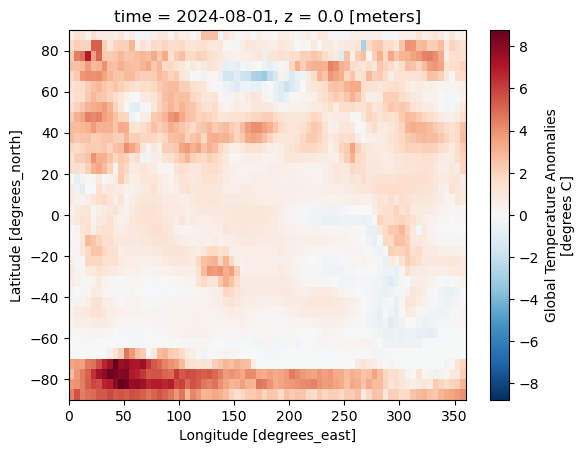

In [4]:
ds['anom'].sel(time='2024-08-01').plot()

In [5]:
# pull the variable 'anom' out of the dataset
da = ds['anom']

# group monthly data into annual-mean time series
da_ann = da.groupby('time.year').mean('time')


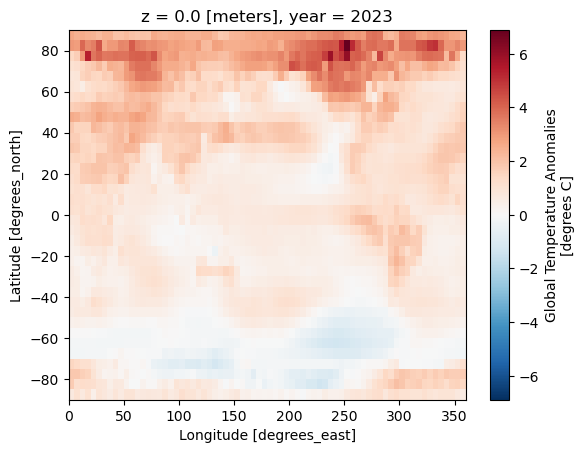

In [6]:
## let's plot annual mean temperature anomalies in 2023
da_ann.sel(year=2023).plot()

## let's look at what happens if we area-weight and don't area-weight gridded data

## first let's take a simple average

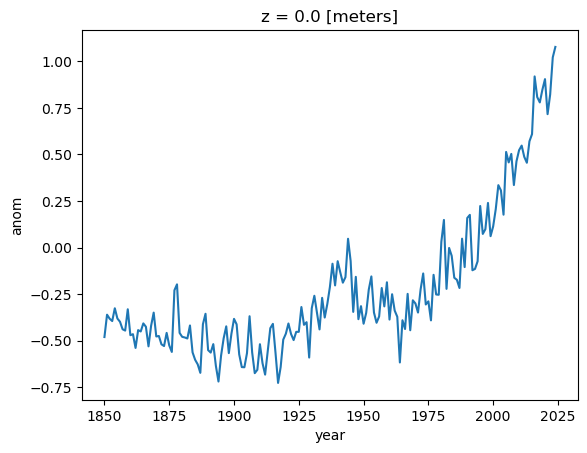

In [7]:
# first just create a simple average, equally weighting all grid points on globe
gmt2m_unweighted = da_ann.mean(dim=('lon','lat'))

gmt2m_unweighted.plot()

#note temperature anomalies are relative to a late 20th century baseline:

In [9]:
#we want to examine how much temperature has changed since the pre-industrial, so let's calculate anomalies from this time period
gmt2m_unweighted_anom_noaa = (gmt2m_unweighted - gmt2m_unweighted.sel(year=slice(1850,1899)).mean(dim='year'))


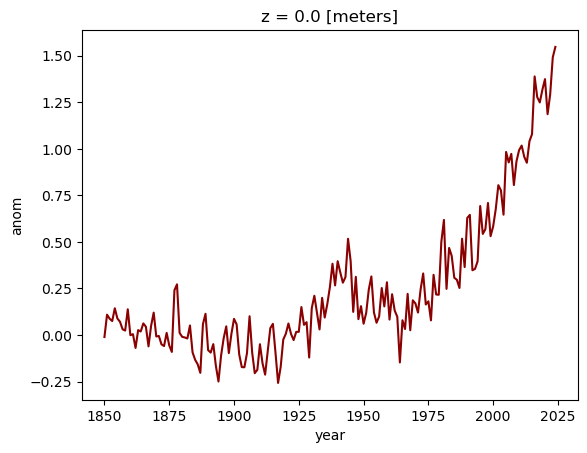

In [10]:
#plot time series
gmt2m_unweighted_anom_noaa.plot(color='darkred',label='Unweighted')

# now create an area-weighted time series


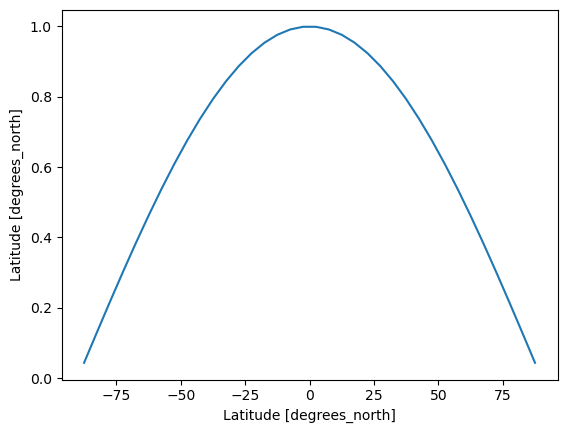

In [11]:
#weight for global mean
w = np.cos(np.deg2rad(da_ann.lat)) #we are going to area-weight by the cosine of the latitude (as we approach poles, data more and more stretched onto grid)
w.plot()

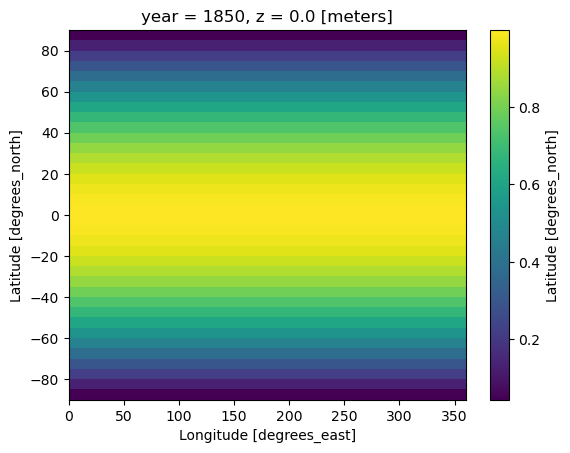

In [12]:
w = w.broadcast_like(da_ann) #broadcast the weighting across all longitudes and time
w.sel(year=1850).plot()

# use these maps of weights to area-weight temperature anomalies

In [14]:
#we can have some missing data, so let's pull out and area-weight the temperature anomalies where no missing data
gmt2m = (w.where(da_ann.notnull()) * da_ann).sum(dim=('lon','lat')) / w.where(da_ann.notnull()).sum(dim=('lon','lat'))


In [15]:
#we want to examine how much temperature has changed since the pre-industrial, so let's calculate anomalies from this time period
gmt2m_anom_noaa = (gmt2m - gmt2m.sel(year=slice(1850,1899)).mean(dim='year')).sel(year=slice(1850,2099))


Text(0.5, 1.0, 'NOAA GlobalTemp Unweighted and Area-Weighted \n Global-Mean, Near-Surface Temperature Anomalies')

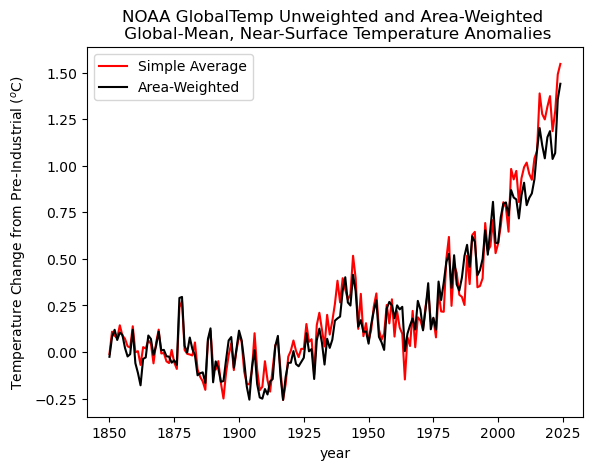

In [17]:
# plot bothtime series
gmt2m_unweighted_anom_noaa.plot(color='red',label='Simple Average')
gmt2m_anom_noaa.plot(color='black',label='Area-Weighted')
#show legend
plt.legend()
plt.ylabel('Temperature Change from Pre-Industrial ($^o$C)')
plt.title('NOAA GlobalTemp Unweighted and Area-Weighted \n Global-Mean, Near-Surface Temperature Anomalies')

## now let's load the climate model (cmip6) data

In [18]:
# Define where catalog is
catalog_url = "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"  # CMIP6 catalog URL on AWS
col = intake.open_esm_datastore(catalog_url)  # Open the CMIP6 catalog using Intake-ESM

#pick which ssp we want to load below
#we are going with ssp585 because it's a high-emissions pathway and we want to examine impacts at warming levels including 3C
#under a lower emissions pathway, like ssp245, some climate models may not reach 3C before 2100
ssp = 'ssp585' 

# Define our query for filtering the data
query = dict(
    variable_id=["tas"],  # Select surface air temperature
    experiment_id=["historical", ssp],  # Select historical and future ssp (e.g., ssp245, ssp585)
    table_id=["Amon"],  # Monthly atmospheric data
    member_id = ["r1i1p1f1"],)  # Specific ensemble member
    #source_id=["ACCESS-CM2"])  # Specify the model

col_subset = col.search(**query)  # Search and filter the catalog based on the query

# Group and display relevant columns to inspect results
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]]

col_subset = col_subset.search(require_all_on=["source_id"], **query)  # Further refine the search to ensure all criteria match
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]]  # Re-check the filtered results


In [19]:
# Filter to only include historical data for the "tas" variable
col_subset_historical = col_subset.search(variable_id=["tas"], experiment_id=["historical"])
col_subset_historical.df.sort_values("source_id")  # Sort the results by source_id

# Filter to only include ssp data in another dictionary for the "tas" variable
col_subset_ssp = col_subset.search(variable_id=["tas"],experiment_id=[ssp])
col_subset_ssp.df.sort_values("source_id")

datasets_historical = col_subset_historical.to_dataset_dict(cdf_kwargs={})  # Convert the filtered results into xarray datasets
datasets_ssp = col_subset_ssp.to_dataset_dict(cdf_kwargs={})

#uncomment next line to display the dataframe
#col_subset_historical.df



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## now we are going to loop through each climate model and load the data


### before we do that, let's load ONE CMIP6 model and take a look at what the loop is doing

In [20]:
# run through the loop without loading the data to see how it works

for hii, hi in enumerate(datasets_historical):  # Loop through historical datasets, hii is the index, hi is the dataset key
    
    ds_historical = datasets_historical[hi]  # Get the historical dataset for the current model
    
    for sii, si in enumerate(datasets_ssp):  # Nested loop through ssp datasets, sii is the index, si is the dataset key
        
        ds_ssp = datasets_ssp[si]  # Get the ssp dataset for the current model
        
        if ds_ssp.attrs['source_id'] == ds_historical.attrs['source_id']:  # Match datasets by model (source_id)

            break
            
da_historical = ds_historical['tas']

da_ssp = ds_ssp['tas']

print('loading data for both experiments from:', ds_historical.attrs['source_id'],ds_ssp.attrs['source_id'])  # Inform which model is being processed


loading data for both experiments from: MPI-ESM1-2-LR MPI-ESM1-2-LR


# let's look at the historical dataset

In [21]:
ds_historical

<xarray.Dataset> Size: 146MB
Dimensions:         (lat: 96, bnds: 2, lon: 192, member_id: 1,
                     dcpp_init_year: 1, time: 1980)
Coordinates:
    height          float64 8B ...
  * lat             (lat) float64 768B -88.57 -86.72 -84.86 ... 86.72 88.57
    lat_bnds        (lat, bnds) float64 2kB dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    lon_bnds        (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
    time_bnds       (time, bnds) datetime64[ns] 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 146MB dask.array<chunksize=(1, 1, 990, 96, 192), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:   time
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM...
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amo...

# let's also look at the ssp dataset

In [22]:
ds_ssp

<xarray.Dataset> Size: 76MB
Dimensions:         (lat: 96, bnds: 2, lon: 192, member_id: 1,
                     dcpp_init_year: 1, time: 1032)
Coordinates:
    height          float64 8B ...
  * lat             (lat) float64 768B -88.57 -86.72 -84.86 ... 86.72 88.57
    lat_bnds        (lat, bnds) float64 2kB dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon             (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    lon_bnds        (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 8kB 2035-01-16T12:00:00 ... 2034-12...
    time_bnds       (time, bnds) datetime64[ns] 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds
Data variables:
    tas             (member_id, dcpp_init_year, time, lat, lon) float32 76MB dask.array<chunksize=(1, 1, 516, 96, 192), meta=np.ndarray>
Attributes: (12/63)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:variable_id:     tas
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          s3://cmip6-pds/CMIP6/ScenarioMIP/MPI-M/...
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585....

## notice we can take out a data array ('tas' variable) from the dataset

In [23]:
da_historical = ds_historical['tas']

da_historical

<xarray.DataArray 'tas' (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 96,
                         lon: 192)> Size: 146MB
dask.array<broadcast_to, shape=(1, 1, 1980, 96, 192), dtype=float32, chunksize=(1, 1, 990, 96, 192), chunktype=numpy.ndarray>
Coordinates:
    height          float64 8B ...
  * lat             (lat) float64 768B -88.57 -86.72 -84.86 ... 86.72 88.57
  * lon             (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
Attributes:
    _ChunkSizes:    [1, 96, 192]
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-09-11T14:13:17Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

## let's make a map of the last time slice in the historical to see what it looks like:
#### note that the 'historical' experiment/runs span 1850-2014


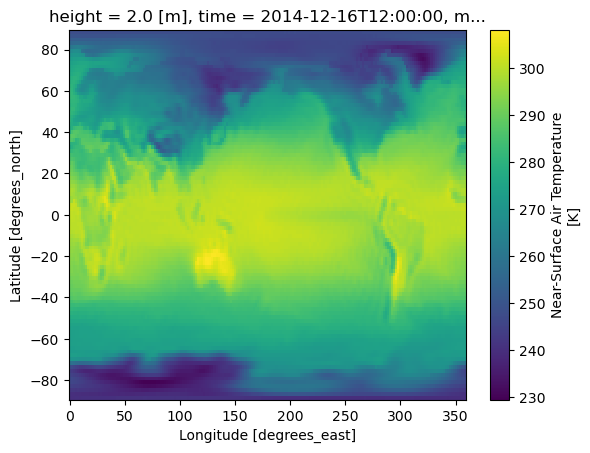

In [24]:
da_historical.sel(time='2014-12-16 12:00:00').plot()

#note units are in Kelvin

# let's do the same for the ssp

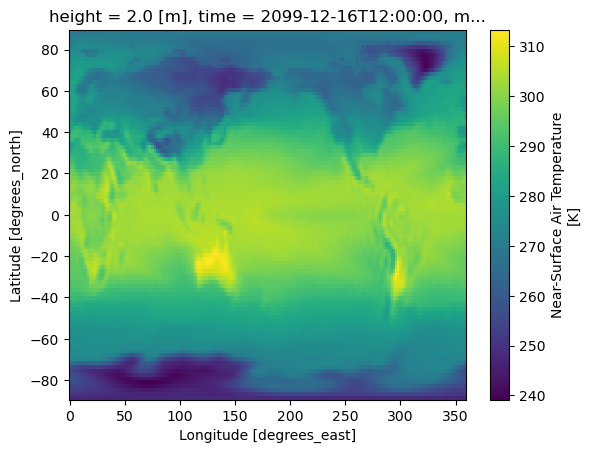

In [25]:
da_ssp = ds_ssp['tas'] 

da_ssp.sel(time='2099-12-16 12:00:00').plot()

#note xarray auto-sets the colorbar limit (it's now 310K!)

## since data are in Kelvin, let's convert to Celsius

In [26]:
# Convert historical 'tas' (temperature) from Kelvin to Celsius
da_historical = (ds_historical['tas'] - 273.15)

da_ssp = (ds_ssp['tas'] - 273.15)


## now we are going to annualize the monthly data
### note that some climate modeling groups may save the temporal range of output in a non-standard way, so we are going to specify the time slice we want to load: 1850-2014

In [27]:
# Calculate the annual mean temperature for historical data (1850-2014)
da_historical_ann = da_historical.groupby('time.year').mean('time').sel(year=slice(1850, 2014))

#same for the ssp, but for 2015-2100
da_ssp_ann = da_ssp.groupby('time.year').mean('time').sel(year=slice(2015, 2100))

In [28]:
# Concatenate the historical and ssp data along the 'year' dimension
da_historical_ssp_ann = xr.concat((da_historical_ann, da_ssp_ann), dim='year')

#note we now have a continuous annual time series: 1850-2100
da_historical_ssp_ann

<xarray.DataArray 'tas' (member_id: 1, dcpp_init_year: 1, year: 251, lat: 96,
                         lon: 192)> Size: 19MB
dask.array<concatenate, shape=(1, 1, 251, 96, 192), dtype=float32, chunksize=(1, 1, 1, 96, 192), chunktype=numpy.ndarray>
Coordinates:
    height          float64 8B 2.0
  * lat             (lat) float64 768B -88.57 -86.72 -84.86 ... 86.72 88.57
  * lon             (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * year            (year) int64 2kB 1850 1851 1852 1853 ... 2097 2098 2099 2100

## now we are going to area-weight by latitude, create global-mean near-surface air temperature time series from maps of data

In [29]:
 # Calculate weights based on latitude for global mean (cosine latitude weighting)
w = np.cos(np.deg2rad(da_historical_ssp_ann.lat))
w = w.broadcast_like(da_historical_ssp_ann)  # Ensure weights have the same shape as the data

# Calculate global mean temperature using area weights (latitude weighted average)
gmt2m = ((w * da_historical_ssp_ann).sum(dim=('lon', 'lat')) / w.sum(dim=('lon', 'lat'))).compute()

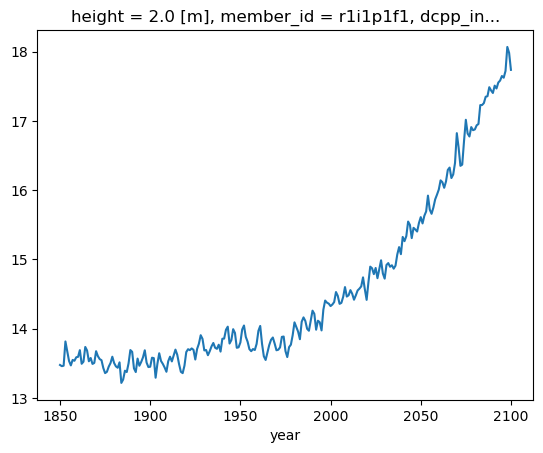

In [30]:
gmt2m.plot()

## loop through and load each climate model- doing the same as above and saving the output at the end of the loop

In [31]:
%%time 
#time how long it takes to loop through all CMIP6 models defined above

#empty list to be filled with each model name
cmip6_models = []

for hii, hi in enumerate(datasets_historical):  # Loop through historical datasets, hii is the index, hi is the dataset key
    
    ds_historical = datasets_historical[hi]  # Get the historical dataset for the current model
    
    for sii, si in enumerate(datasets_ssp):  # Nested loop through ssp datasets, sii is the index, si is the dataset key
        
        ds_ssp = datasets_ssp[si]  # Get the ssp dataset for the current model
        
        if ds_ssp.attrs['source_id'] == ds_historical.attrs['source_id']:  # Match datasets by model (source_id)
            
            print('loading data for both experiments from:', ds_ssp.attrs['source_id'])  # Inform which model is being processed

            #append this model's name to list
            cmip6_models.append(ds_ssp.attrs['source_id'])
            
            # Convert historical 'tas' (temperature) from Kelvin to Celsius
            da_historical = (ds_historical['tas'] - 273.15)
            
            # Calculate the annual mean temperature for historical data (1850-2014)
            da_historical_ann = da_historical.groupby('time.year').mean('time').sel(year=slice(1850, 2014))
            
            # Convert ssp 'tas' (temperature) from Kelvin to Celsius
            da_ssp = ds_ssp['tas'] - 273.15
            
            # Calculate the annual mean temperature for ssp data (2015-2100)
            da_ssp_ann = da_ssp.groupby('time.year').mean('time').sel(year=slice(2015, 2100))

            # Concatenate the historical and ssp data along the 'year' dimension
            da_historical_ssp_ann = xr.concat((da_historical_ann, da_ssp_ann), dim='year')
            
            # Calculate weights based on latitude for global mean (cosine latitude weighting)
            w = np.cos(np.deg2rad(da_historical_ssp_ann.lat))
            w = w.broadcast_like(da_historical_ssp_ann)  # Ensure weights have the same shape as the data
            
            # Calculate global mean temperature using area weights (latitude weighted average)
            gmt2m = ((w * da_historical_ssp_ann).sum(dim=('lon', 'lat')) / w.sum(dim=('lon', 'lat'))).compute()
            
            if hii == 0:  # For the first iteration, initialize the global mean temperature (gmt) collection
                cmip6_gmtm = gmt2m
            else:
                # For subsequent iterations, concatenate the global mean temperature data along the 'model' dimension
                cmip6_gmtm = xr.concat((cmip6_gmtm, gmt2m), dim='model')


loading data for both experiments from: FGOALS-f3-L
loading data for both experiments from: AWI-CM-1-1-MR
loading data for both experiments from: ACCESS-CM2
loading data for both experiments from: CanESM5
loading data for both experiments from: NESM3
loading data for both experiments from: MIROC6
loading data for both experiments from: KIOST-ESM
loading data for both experiments from: MRI-ESM2-0
loading data for both experiments from: CMCC-ESM2
loading data for both experiments from: IPSL-CM6A-LR
loading data for both experiments from: FIO-ESM-2-0
loading data for both experiments from: KACE-1-0-G
loading data for both experiments from: IITM-ESM
loading data for both experiments from: E3SM-1-1
loading data for both experiments from: INM-CM5-0
loading data for both experiments from: EC-Earth3
loading data for both experiments from: CIESM
loading data for both experiments from: CAS-ESM2-0
loading data for both experiments from: ACCESS-ESM1-5
loading data for both experiments from: EC-Ear

## compute anomalies (changes) from pre-industrial time period (typically defined as ~1850-1900)

In [32]:
cmip6_gmtm_anom = (
    cmip6_gmtm 
    - cmip6_gmtm.sel(year=slice(1850,1899)).mean(dim='year')
).sel(year=slice(1850,2100)).compute()  # Calculate temperature anomalies relative to the 1850-1899 mean, select data for 1850-2100, and compute

cmip6_gmtm_anom = cmip6_gmtm_anom.squeeze()  # Remove any singleton dimensions from the data (e.g., a dimension of size 1)


## take a quick look at the data in a plot

Text(0.5, 1.0, 'CMIP6 hist+ssp585 NOAA GlobalTemp Global-Mean tas anomalies')

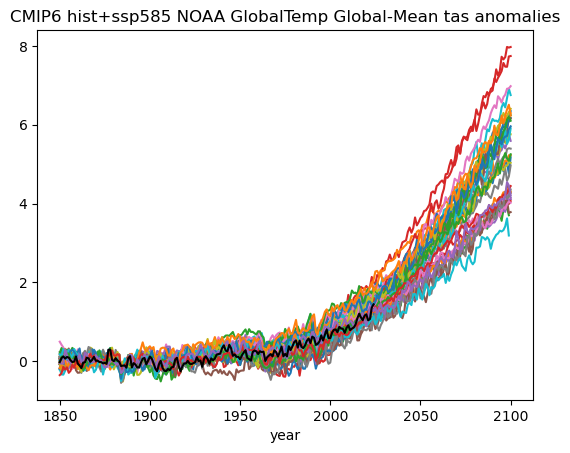

In [33]:
#loop through each climade model, plot 
for mi,model in enumerate(cmip6_models):
    cmip6_gmtm_anom.sel(model=mi).plot()
    
#plot noaa temperature anomalies on top of climate model data
gmt2m_anom_noaa.plot(color='black')

#make title for graph
plt.title('CMIP6 hist+'+str(ssp)+' NOAA GlobalTemp Global-Mean tas anomalies')

## calculate when global-mean temperature anomalies cross temperature thresholds in annual and 20-year smoothed data
#### note that we are looking at when a 20-year rolling average and annual averages cross certain warming thresholds- we will see later that due to interannual climate variability, we can cross a thresold like 1C or 1.5C for a year, then re-cross it later- according to the IPCC, we should be interested in when global temperatures consistently cross these thresholds- usually we can assess this using a rolling average of 20 or 30 years.

In [34]:
rolling_ave_window = 20  # Set the window size for the rolling average (20 years)
temps = [1, 1.5, 2, 2.5, 3]  # List of temperature thresholds (in degrees Celsius) to analyze

for ti, temp in enumerate(temps):  # Loop through each temperature threshold
    
    print('assessing when each climate model reaches',temp,'C Global Warming Threshold')
    
    # Initialize empty lists for storing years when temperature thresholds are reached
    vars()['firstyear_rolling_' + str(temp) + 'C'] = []
    
    for mi, model in enumerate(cmip6_models):  # Loop through each model in the ssp dataset
        
        # Select annual data for the current model
        annual = cmip6_gmtm_anom.sel(model=mi)
        
        # Calculate the rolling average (20-year window) for annual data
        smoothed = annual.rolling(year=rolling_ave_window, center=True).mean()
        
        # Find the first year where the rolling mean matches the temperature threshold
        year_temp_smoothed = (smoothed.year.where(smoothed >= temp, drop=True)).year.min().item()
        
        # Append to the rolling average list
        vars()['firstyear_rolling_' + str(temp) + 'C'].append(year_temp_smoothed)  
        

assessing when each climate model reaches 1 C Global Warming Threshold
assessing when each climate model reaches 1.5 C Global Warming Threshold
assessing when each climate model reaches 2 C Global Warming Threshold
assessing when each climate model reaches 2.5 C Global Warming Threshold
assessing when each climate model reaches 3 C Global Warming Threshold


## save when each model crosses the global warming threshold

In [35]:
#put all data together in a numpy array
all_temps_rolling = np.vstack((
    np.array(vars()['firstyear_rolling_'+str(1)+'C']),
    np.array(vars()['firstyear_rolling_'+str(1.5)+'C']),
    np.array(vars()['firstyear_rolling_'+str(2)+'C']),
    np.array(vars()['firstyear_rolling_'+str(2.5)+'C']),
    np.array(vars()['firstyear_rolling_'+str(3)+'C']),
                      )
                     ).T

#use pandas to save as a data frame
cmip6_models_warminglevels_df_rolling = pd.DataFrame(data=(all_temps_rolling),
             index=cmip6_models,
            columns=temps)  # 1st row as the column names

#rename index column as CMIP6 Model
cmip6_models_warminglevels_df_rolling.index.name = 'CMIP6 Model'

#data are output randomly as they were found on the storage- we want to organize by alphabetical order
cmip6_models_warminglevels_df_rolling = cmip6_models_warminglevels_df_rolling.sort_index()

#save dataframe as csv file for importing later or downloading
cmip6_models_warminglevels_df_rolling.to_csv('CMIP6_nModels_'+str(len(cmip6_models))+'_GWLevels_'+str(ssp)+'_Smoothed_FirstYearThreshold.csv')

## print when reach 2C global warming in this ssp, and then 


In [36]:
#select a global warming threshold of 2C
temp = 2

print('Rolling method median:',np.median(np.array(vars()['firstyear_rolling_'+str(temp)+'C'])))
print('Rolling method 5th percentile:',np.quantile(np.array(vars()['firstyear_rolling_'+str(temp)+'C']),0.05))
print('Rolling method 95th percentile:',np.quantile(np.array(vars()['firstyear_rolling_'+str(temp)+'C']),0.95))


Rolling method median: 2039.0
Rolling method 5th percentile: 2026.8
Rolling method 95th percentile: 2055.6


## make a PDF of this distribution when the models hit 2C warming

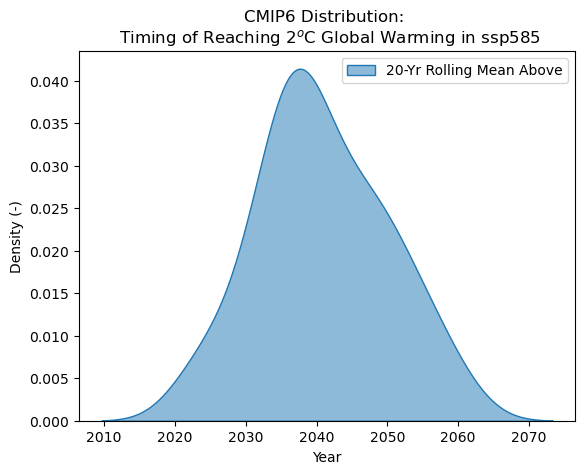

In [37]:


# Plot PDF of when reach these thresholds using seaborn
sns.kdeplot(np.array(vars()['firstyear_rolling_'+str(temp)+'C']),alpha=0.5,fill=True,label='20-Yr Rolling Mean Above')
plt.title('CMIP6 Distribution: \n Timing of Reaching '+str(temp)+'$^o$C Global Warming in '+str(ssp))
plt.xlabel('Year')
plt.ylabel('Density (-)')
plt.legend()
plt.show()


## make line graph of gmtas, and plot dots when each climate model reaches a given warming level

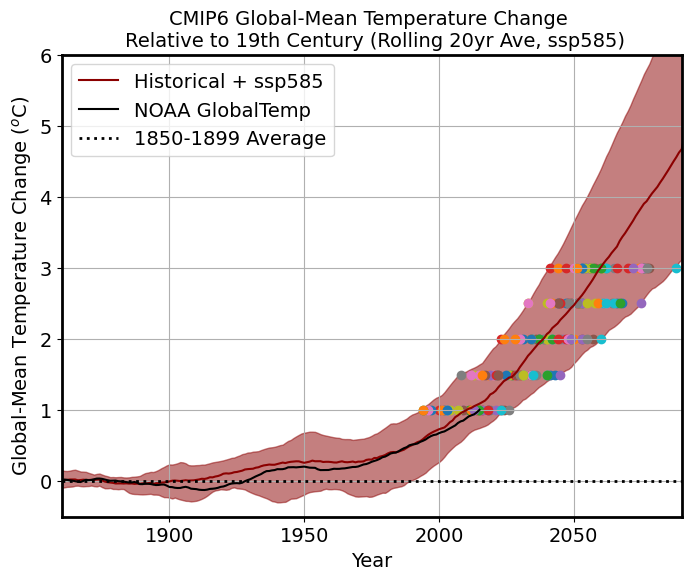

In [38]:
time = cmip6_gmtm_anom.year

fsize = 14

fig = plt.figure(figsize=(8,6)) #set figure size

ax = plt.subplot(1,1,1)

#we are going to create a shaded error bar region showing the spread in climate model data
plt.fill_between(time,
                 cmip6_gmtm_anom.rolling(year=rolling_ave_window, center=True).mean().max(dim='model'),
                 cmip6_gmtm_anom.rolling(year=rolling_ave_window, center=True).mean().min(dim='model'),
                 color='darkred',
                alpha=0.5) #alpha is opacity of the shading

# let's also create a line showing the multi-model median
plt.plot(time,
         cmip6_gmtm_anom.rolling(year=rolling_ave_window, center=True).mean().median(dim='model'),
         color='darkred',
        label='Historical + '+str(ssp))

#now let's add dots on the shaded area showing where each climate model hits the warming threshold
for ti,temp in enumerate(temps):
    for mi,model in enumerate(cmip6_models):
        plt.scatter(vars()['firstyear_rolling_'+str(temp)+'C'][mi],temp)

#for fun, let's plot the NOAA observation based data on top
gmt2m_anom_noaa.rolling(year=rolling_ave_window, center=True).mean().plot(color='black',label='NOAA GlobalTemp')

plt.xlim(1860,2090)
plt.ylim(-0.5,6)
plt.grid()
plt.axhline(0, color='black', linestyle=':',linewidth=2,label=('1850-1899 Average'))
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel('Year',fontsize=fsize)
plt.ylabel('Global-Mean Temperature Change ($^o$C)',fontsize=fsize)
plt.legend(loc='upper left',fontsize=fsize)
plt.title('CMIP6 Global-Mean Temperature Change \n Relative to 19th Century (Rolling 20yr Ave, '+str(ssp)+')',fontsize=fsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)


## plot the same, but for annual

In [ ]:
time = cmip6_gmtm_anom.year

fsize = 14

fig = plt.figure(figsize=(8,6)) #set figure size

ax = plt.subplot(1,1,1)

plt.fill_between(time,
                 cmip6_gmtm_anom.max(dim='model'),
                 cmip6_gmtm_anom.min(dim='model'),
                 color='darkred',
                alpha=0.5)
plt.plot(time,
         cmip6_gmtm_anom.median(dim='model'),
         color='darkred',
        label='Historical + '+str(ssp))

for ti,temp in enumerate(temps):
    for mi,model in enumerate(cmip6_models):
        plt.scatter(vars()['firstyear_'+str(temp)+'C'][mi],temp,color='red',alpha=0.5)
        plt.scatter(vars()['year_consistent_above_'+str(temp)+'C'][mi],temp,color='black',alpha=0.5)

gmt2m_anom_noaa.plot(color='black',label='NOAA GlobalTemp')

plt.xlim(1850,2099)
plt.ylim(-0.5,6)
plt.grid()
plt.axhline(0, color='black', linestyle=':',linewidth=2,label=('1850-1899 Average'))
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel('Year',fontsize=fsize)
plt.ylabel('Global-Mean Temperature Change ($^o$C)',fontsize=fsize)
plt.legend(loc='upper left',fontsize=fsize)
plt.title('CMIP6 Global-Mean Temperature Change \n Relative to 19th Century ('+str(ssp)+')',fontsize=fsize)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
